In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

tf.random.set_seed(42)

## 데이터셋 불러오기

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
# normalization
X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
# reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [6]:
# one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## 모델 구성

In [7]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, input_shape=(28,28,1), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(2,2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

In [8]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

## 체크포인트 설정

In [9]:
checkpoint_path = 'training/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True, 
    verbose=1)

model.save_weights(checkpoint_path.format(epoch=0))

## 모델 훈련

In [10]:
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test), callbacks=[cp_callback])

Epoch 1/10
938/938 [==============================] - 207s 221ms/step - loss: 0.1758 - accuracy: 0.9468 - val_loss: 0.0270 - val_accuracy: 0.9916

Epoch 00001: saving model to training/cp-001.ckpt
Epoch 2/10
938/938 [==============================] - 234s 249ms/step - loss: 0.0568 - accuracy: 0.9845 - val_loss: 0.0365 - val_accuracy: 0.9888

Epoch 00002: saving model to training/cp-002.ckpt
Epoch 3/10
938/938 [==============================] - 203s 217ms/step - loss: 0.0415 - accuracy: 0.9885 - val_loss: 0.0189 - val_accuracy: 0.9942

Epoch 00003: saving model to training/cp-003.ckpt
Epoch 4/10
938/938 [==============================] - 203s 216ms/step - loss: 0.0326 - accuracy: 0.9915 - val_loss: 0.0252 - val_accuracy: 0.9924

Epoch 00004: saving model to training/cp-004.ckpt
Epoch 5/10
938/938 [==============================] - 203s 216ms/step - loss: 0.0268 - accuracy: 0.9925 - val_loss: 0.0286 - val_accuracy: 0.9923

Epoch 00005: saving model to training/cp-005.ckpt
Epoch 6/10
938/

## 모델 성능 테스트

In [11]:
loss, acc = model.evaluate(X_test, y_test, verbose=1)
print('accuracy: {:5.2f}%'.format(acc*100))

313/313 [==============================] - 9s 28ms/step - loss: 0.0272 - accuracy: 0.9935
accuracy: 99.35%


## 실제 이미지로 잘 인식 되는지 테스트

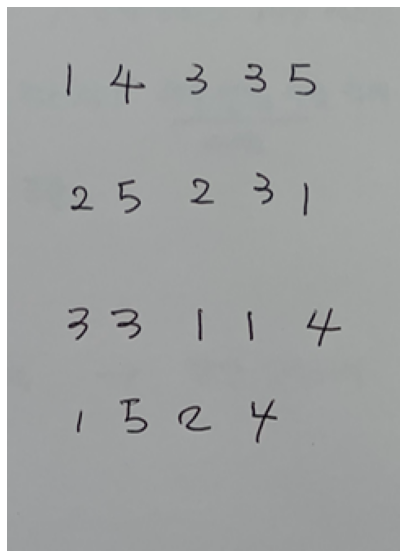

In [12]:
# 샘플 이미지 불러오기
img = cv2.imread('noname01.png')
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.axis('off')
plt.show()

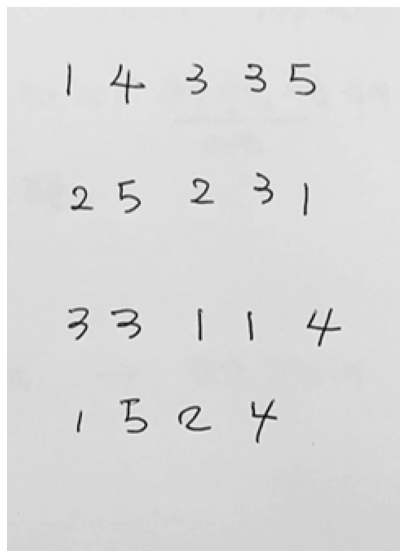

In [13]:
# 그레이스케일로 변환
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(20,10))
plt.imshow(img_gray, cmap='gray')
plt.axis('off')
plt.show()

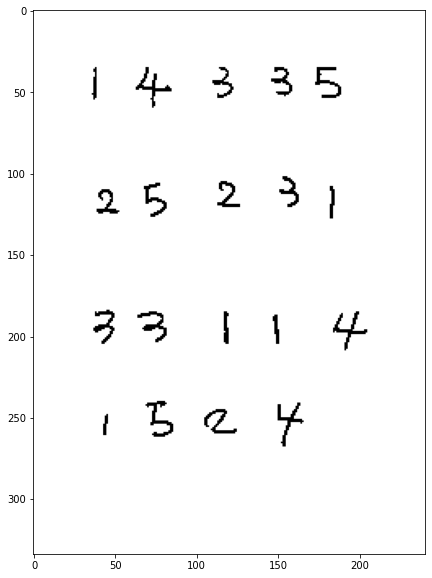

In [14]:
# image threshold test for binarization
ret, flag = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(20,10))
plt.imshow(flag, cmap='gray')
plt.show()

In [15]:
# detect only numbers
ret, img_th = cv2.threshold(flag, 127, 255, cv2.THRESH_BINARY_INV)
contours, hierachy = cv2.findContours(img_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [16]:
# 답안의 순서를 매기기 위한 함수
def contour_rank(contour, cols):
    tolerance_factor = 50
    origin = cv2.boundingRect(contour)
    return ((origin[1] // tolerance_factor) * tolerance_factor) * cols + origin[0]

In [17]:
contours.sort(key=lambda x:contour_rank(x, img_th.shape[1]))

In [18]:
rects = [cv2.boundingRect(contour) for contour in contours]
rects

[(36, 35, 3, 20),
 (63, 35, 22, 25),
 (110, 35, 13, 19),
 (146, 35, 13, 18),
 (173, 35, 16, 19),
 (39, 110, 14, 15),
 (68, 106, 14, 21),
 (113, 105, 14, 16),
 (151, 102, 12, 19),
 (182, 108, 3, 20),
 (37, 184, 13, 21),
 (64, 185, 18, 19),
 (117, 185, 3, 20),
 (147, 187, 4, 18),
 (184, 185, 21, 24),
 (43, 248, 3, 13),
 (69, 240, 17, 22),
 (105, 245, 20, 15),
 (150, 241, 16, 27)]

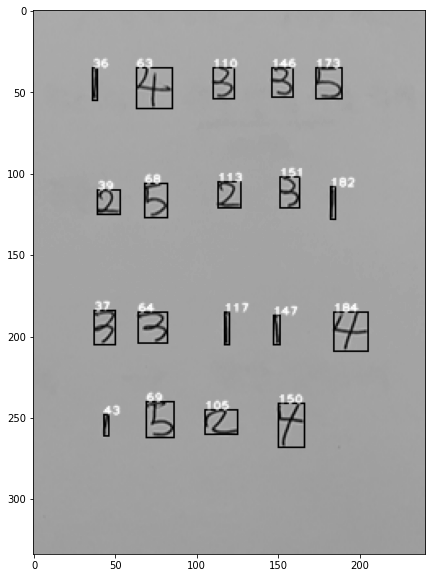

In [19]:
# bounding boxes for detected numbers
for rect in rects:
    cv2.rectangle(img_gray, (rect[0], rect[1]), 
                  (rect[0]+rect[2], rect[1]+rect[3]), 
                  (0,255,0), 1)
    cv2.putText(img_gray, str(rect[0]), (rect[0], rect[1]), cv2.FONT_HERSHEY_PLAIN, 0.5, (255,0,0), 1, cv2.LINE_AA)
    
plt.figure(figsize=(20,10))
plt.imshow(img_gray, cmap='gray')

In [20]:
img_for_class = flag.copy()

(36, 35, 3, 20)


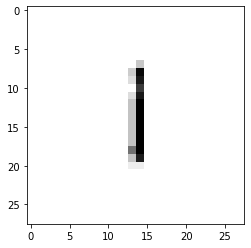

(63, 35, 22, 25)


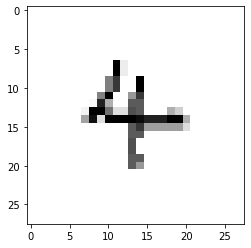

(110, 35, 13, 19)


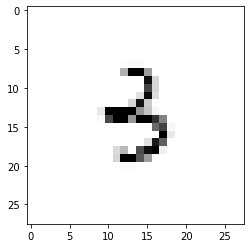

(146, 35, 13, 18)


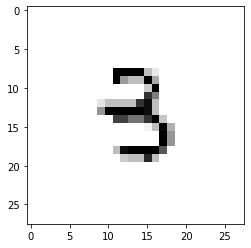

(173, 35, 16, 19)


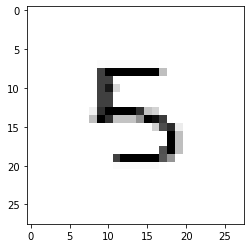

(39, 110, 14, 15)


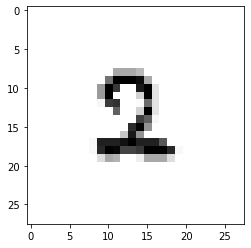

(68, 106, 14, 21)


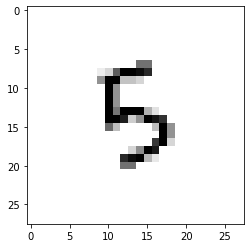

(113, 105, 14, 16)


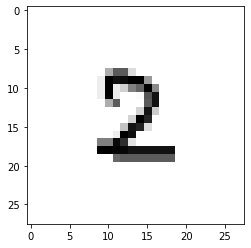

(151, 102, 12, 19)


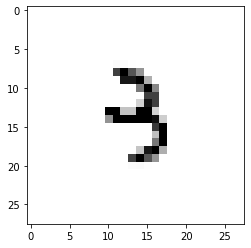

(182, 108, 3, 20)


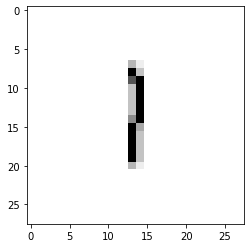

(37, 184, 13, 21)


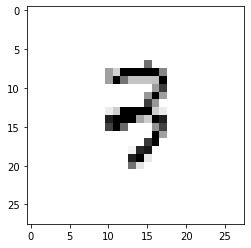

(64, 185, 18, 19)


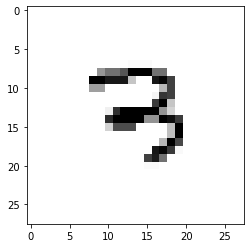

(117, 185, 3, 20)


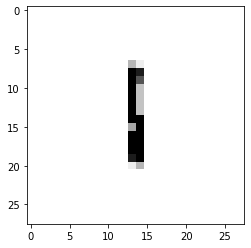

(147, 187, 4, 18)


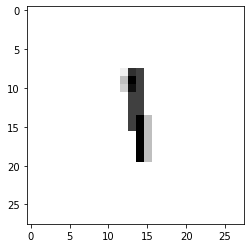

(184, 185, 21, 24)


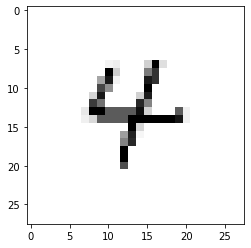

(43, 248, 3, 13)


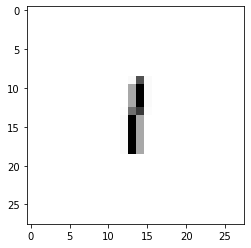

(69, 240, 17, 22)


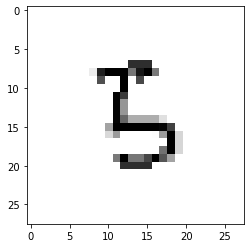

(105, 245, 20, 15)


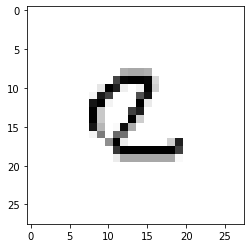

(150, 241, 16, 27)


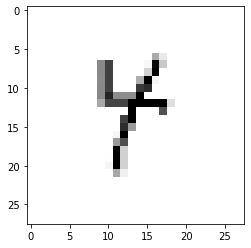

In [21]:
# 인식된 숫자들에 마진을 주고 28x28 사이즈로 크롭

mnist_imgs = []
margin = 12

for rect in rects:
    print(rect)
    # detect number area
    im = img_for_class[rect[1]-margin : rect[1]+rect[3]+margin, 
                       rect[0]-margin : rect[0]+rect[2]+margin]
    row, col = im.shape[:2]
    
    border_size = max(row, col)
    diff = min(row, col)
    
    bottom = im[row-2:row, 0:col]
    mean = cv2.mean(bottom)[0]
    
    border = cv2.copyMakeBorder(
        im,
        top=0, 
        bottom=0, 
        left=int((border_size - diff) / 2), 
        right=int((border_size - diff) / 2),
        borderType=cv2.BORDER_CONSTANT, 
        value=[mean, mean, mean]
    )
    
    square = border
    plt.imshow(square)
    
    resized_img = cv2.resize(square, dsize=(28,28), interpolation=cv2.INTER_LINEAR)
    mnist_imgs.append(resized_img)
    plt.imshow(resized_img, cmap='gray')
    plt.show()

In [22]:
model = tf.keras.models.load_model('mnist_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)             

In [23]:
answers = []
for i in range(len(mnist_imgs)):
    img = mnist_imgs[i].reshape(-1, 28, 28, 1)
    input_data = ((np.array(img) / 255.0) - 1) * -1
    answers.append(int(np.argmax(model.predict(input_data), axis=-1)))

In [24]:
answers

[1, 4, 3, 3, 5, 2, 5, 2, 3, 1, 3, 3, 1, 1, 4, 1, 5, 2, 4]